# Assignment-1: Linear Regression Model for Employee Attrition Prediction 

**Dataset:** HR_Employee.csv  
**Target Variable:** Attrition  
**Input Variables (8):** Age, MonthlyIncome, TotalWorkingYears, YearsAtCompany, DistanceFromHome, JobSatisfaction, EnvironmentSatisfaction, YearsWithCurrManager  
**Note:** Linear Regression is implemented from scratch using NumPy (Normal Equation), without using scikit-learn.

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load the Dataset

In [3]:
df = pd.read_csv('HR_Employee.csv')
print(f"Dataset Shape: {df.shape}")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")
df.head()

Dataset Shape: (1470, 35)
Number of Rows: 1470
Number of Columns: 35


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## 3. Dataset Overview

In [4]:
print("=" * 60)
print("DATASET INFO")
print("=" * 60)
df.info()

DATASET INFO
<class 'pandas.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1470 non-null   int64
 1   Attrition                 1470 non-null   str  
 2   BusinessTravel            1470 non-null   str  
 3   DailyRate                 1470 non-null   int64
 4   Department                1470 non-null   str  
 5   DistanceFromHome          1470 non-null   int64
 6   Education                 1470 non-null   int64
 7   EducationField            1470 non-null   str  
 8   EmployeeCount             1470 non-null   int64
 9   EmployeeNumber            1470 non-null   int64
 10  EnvironmentSatisfaction   1470 non-null   int64
 11  Gender                    1470 non-null   str  
 12  HourlyRate                1470 non-null   int64
 13  JobInvolvement            1470 non-null   int64
 14  JobLevel                  1470 non-nul

In [5]:
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
df.describe()

STATISTICAL SUMMARY


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [6]:
print("=" * 60)
print("MISSING VALUES")
print("=" * 60)
print(df.isnull().sum())
print(f"\nTotal Missing Values: {df.isnull().sum().sum()}")

MISSING VALUES
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole       

In [7]:
print("=" * 60)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 60)
print(df['Attrition'].value_counts())
print(f"\nAttrition Rate: {df['Attrition'].value_counts(normalize=True)['Yes']*100:.2f}%")

TARGET VARIABLE DISTRIBUTION
Attrition
No     1233
Yes     237
Name: count, dtype: int64

Attrition Rate: 16.12%


## 4. Exploratory Data Analysis (EDA)

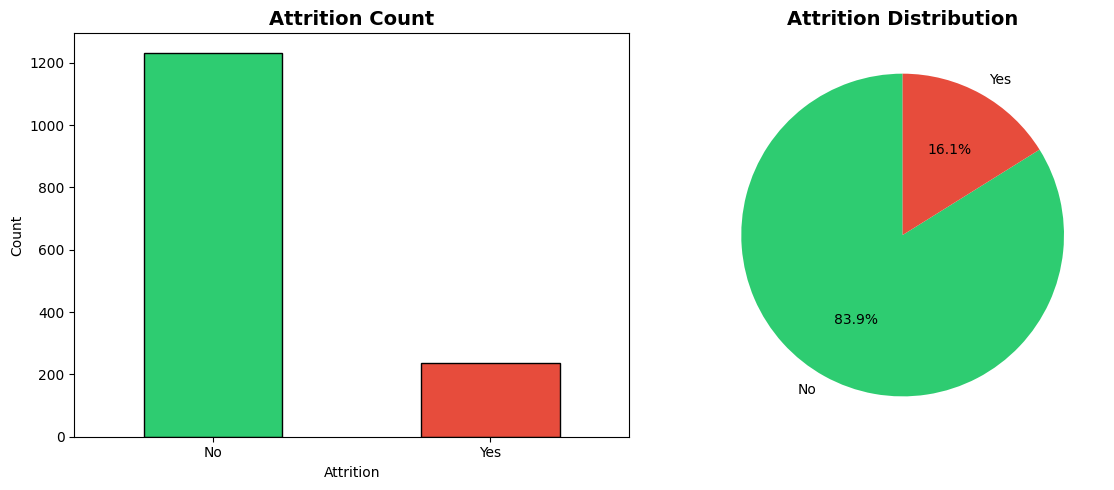

In [8]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#2ecc71', '#e74c3c']
df['Attrition'].value_counts().plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Attrition Count', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Attrition')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

df['Attrition'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Attrition Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

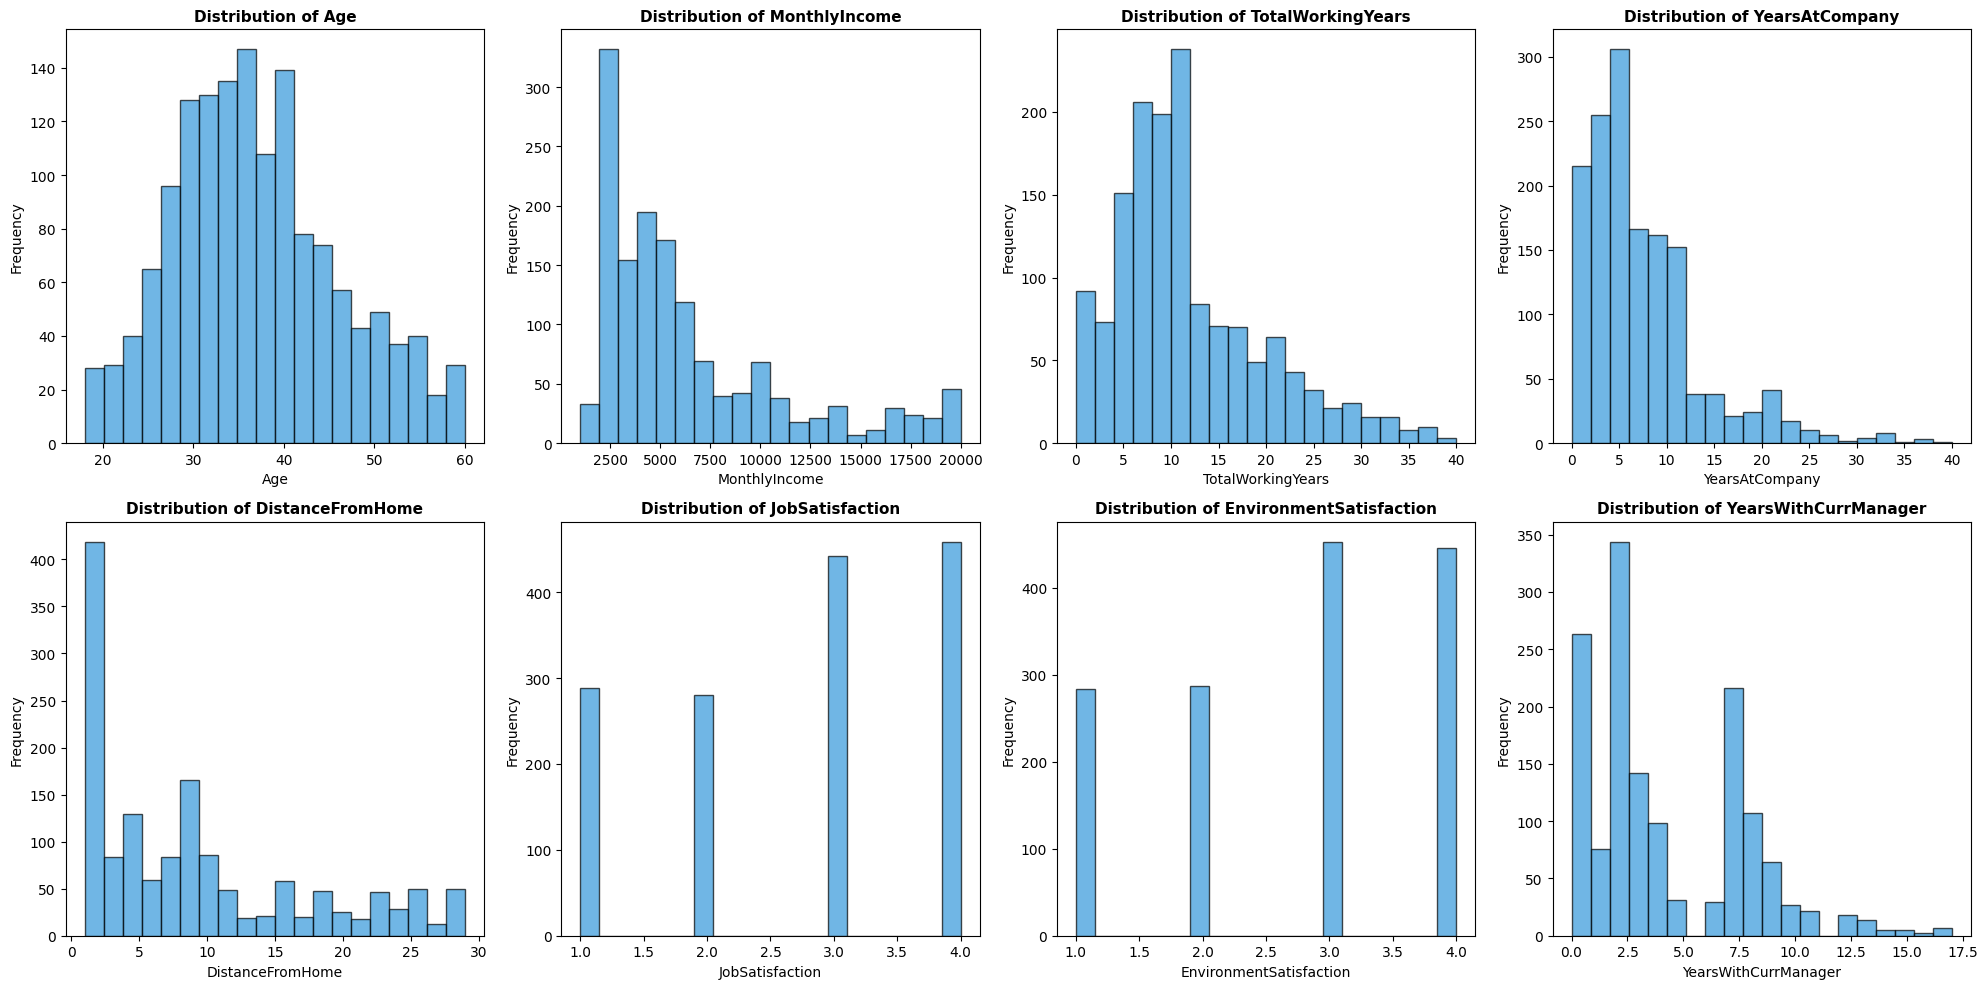

In [9]:
# Distribution of selected input features
input_features = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany',
                   'DistanceFromHome', 'JobSatisfaction', 'EnvironmentSatisfaction', 'YearsWithCurrManager']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(input_features):
    axes[i].hist(df[col], bins=20, color='#3498db', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

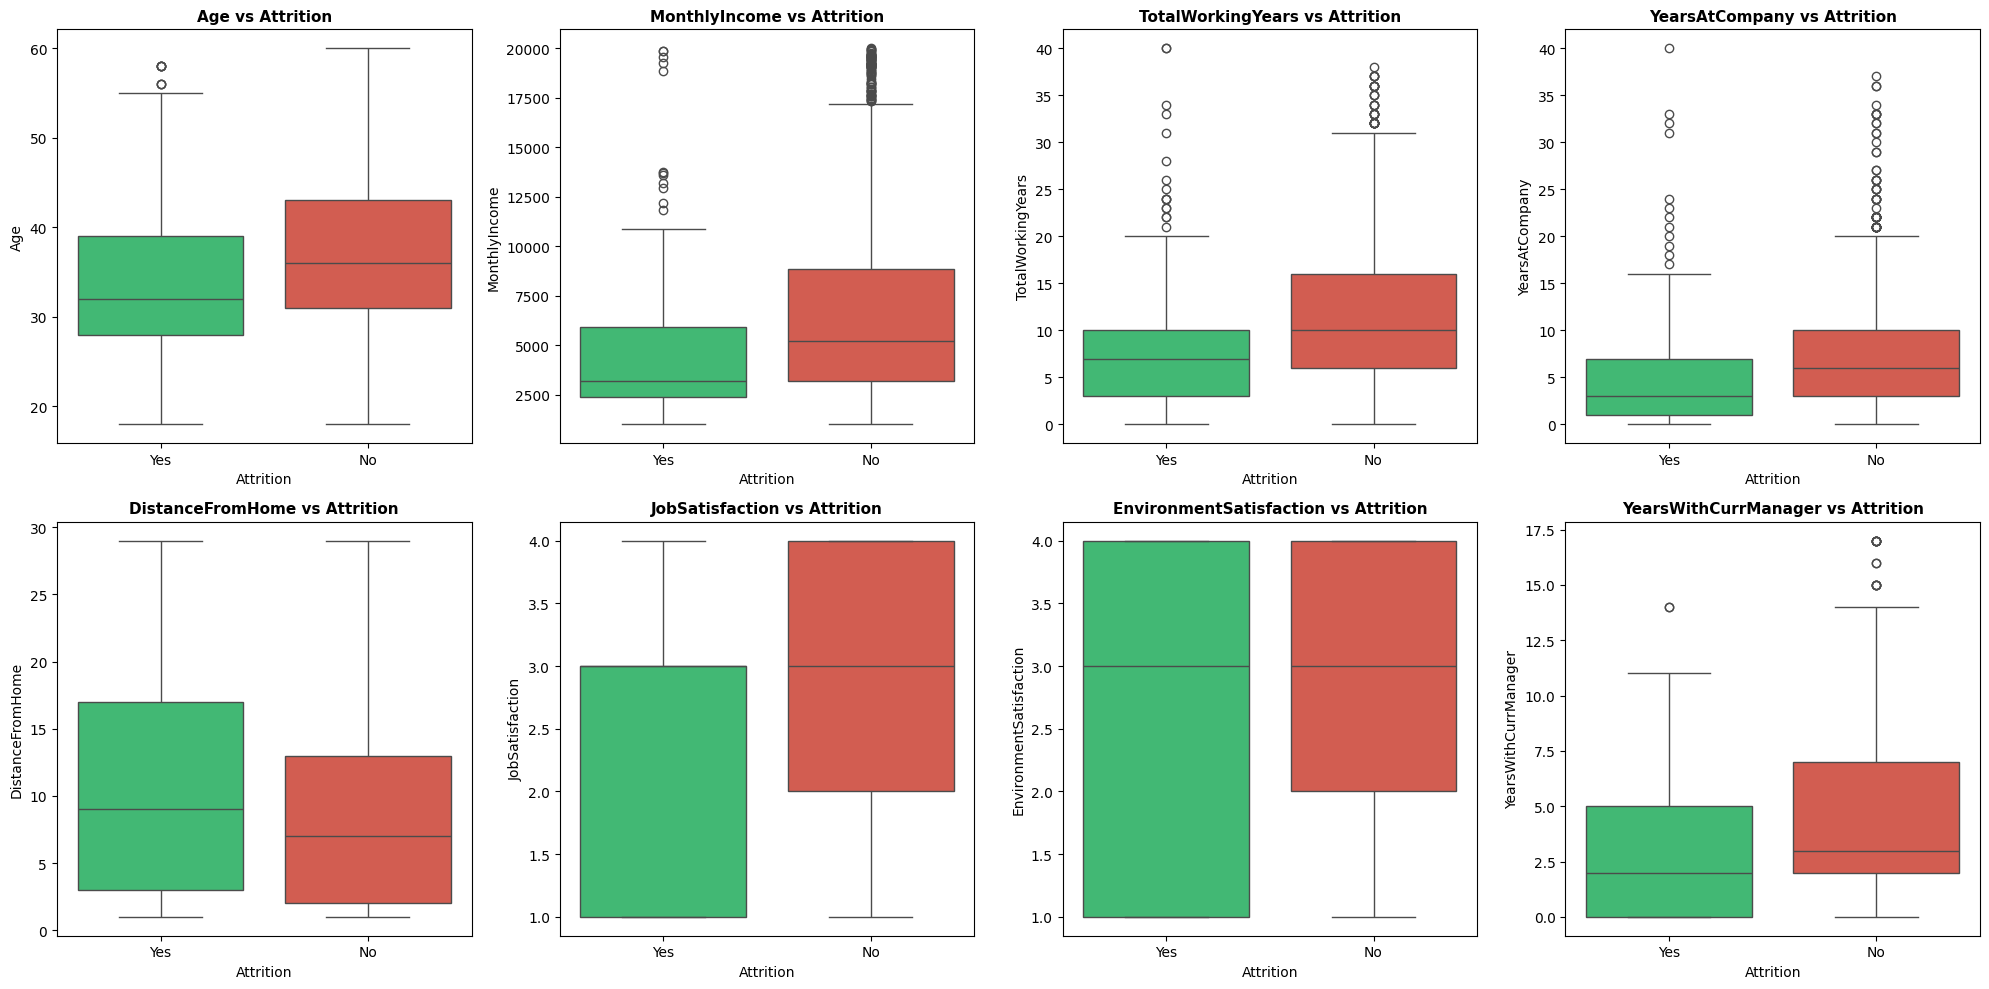

In [10]:
# Box plots - Features vs Attrition
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(input_features):
    sns.boxplot(x='Attrition', y=col, data=df, ax=axes[i], palette=colors)
    axes[i].set_title(f'{col} vs Attrition', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

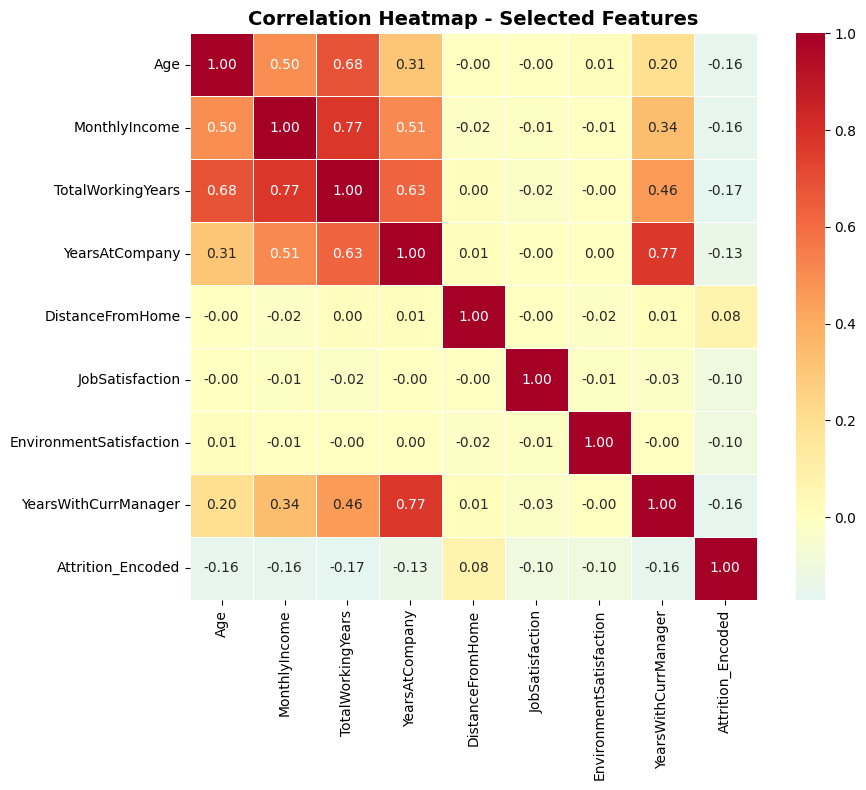

In [11]:
# Encode Attrition: Yes = 1, No = 0
df['Attrition_Encoded'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Correlation heatmap for selected features
selected_cols = input_features + ['Attrition_Encoded']
corr_matrix = df[selected_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
            linewidths=0.5, square=True)
plt.title('Correlation Heatmap - Selected Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Data Preprocessing

In [12]:
# Define input (X) and output (y)
X = df[input_features].values
y = df['Attrition_Encoded'].values

print("Input Features (X):")
print(input_features)
print(f"\nShape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"\nTarget Encoding: No -> 0, Yes -> 1")

Input Features (X):
['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'DistanceFromHome', 'JobSatisfaction', 'EnvironmentSatisfaction', 'YearsWithCurrManager']

Shape of X: (1470, 8)
Shape of y: (1470,)

Target Encoding: No -> 0, Yes -> 1


In [13]:
# Train-Test Split from scratch (80-20 split)
np.random.seed(42)
indices = np.random.permutation(len(X))
split_point = int(0.8 * len(X))

train_idx = indices[:split_point]
test_idx = indices[split_point:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size:  {X_test.shape[0]} samples")
print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape:  X_test={X_test.shape}, y_test={y_test.shape}")

Training set size: 1176 samples
Testing set size:  294 samples

Training set shape: X_train=(1176, 8), y_train=(1176,)
Testing set shape:  X_test=(294, 8), y_test=(294,)


## 6. Linear Regression 

Using the **Normal Equation**:  
$$\theta = (X^T X)^{-1} X^T y$$

Where:
- $X$ = input feature matrix (with bias column of 1s)
- $y$ = target vector
- $\theta$ = model parameters (weights + bias)

## 7. Linear Regression class

In [24]:
class LinearRegressionScratch:
    """
    Linear Regression implemented from scratch using the Normal Equation.
    No scikit-learn dependency.
    """
    
    def __init__(self):
        self.weights = None   # model weights (coefficients)
        self.bias = None      # intercept
    
    def fit(self, X, y):
        """Train the model using the Normal Equation: theta = (X^T X)^(-1) X^T y"""
        n_samples = X.shape[0]
        
        # Add bias column (column of 1s) to X
        X_bias = np.c_[np.ones(n_samples), X]
        
        # Normal Equation: theta = (X^T X)^(-1) X^T y
        XtX = X_bias.T.dot(X_bias)
        Xty = X_bias.T.dot(y)
        theta = np.linalg.inv(XtX).dot(Xty)
        
        # Extract bias and weights
        self.bias = theta[0]
        self.weights = theta[1:]
        
        return self
    
    def predict(self, X):
        """Make predictions: y_pred = X * weights + bias"""
        return X.dot(self.weights) + self.bias

print("Linear Regression class defined (Normal Equation).")

Linear Regression class defined (Normal Equation).


In [15]:
# Train the model
model = LinearRegressionScratch()
model.fit(X_train, y_train)

print("Model trained successfully!")
print(f"\nIntercept (bias): {model.bias:.4f}")
print(f"\nCoefficients (weights):")
for feature, coef in zip(input_features, model.weights):
    print(f"  {feature:30s}: {coef:.6f}")

Model trained successfully!

Intercept (bias): 0.5394

Coefficients (weights):
  Age                           : -0.003247
  MonthlyIncome                 : -0.000008
  TotalWorkingYears             : 0.000777
  YearsAtCompany                : 0.003216
  DistanceFromHome              : 0.002734
  JobSatisfaction               : -0.039412
  EnvironmentSatisfaction       : -0.035279
  YearsWithCurrManager          : -0.016094


## 7. Make Predictions

In [16]:
# Predict on test set
y_pred = model.predict(X_test)

# Display first 10 predictions
results_df = pd.DataFrame({
    'Actual': y_test[:10],
    'Predicted (Raw)': np.round(y_pred[:10], 4),
    'Predicted (Rounded)': (y_pred[:10] >= 0.5).astype(int)
})
print("First 10 Predictions:")
print(results_df.to_string(index=False))

First 10 Predictions:
 Actual  Predicted (Raw)  Predicted (Rounded)
      0           0.2310                    0
      0           0.3062                    0
      1           0.1826                    0
      0           0.2612                    0
      0           0.0978                    0
      0           0.0208                    0
      0           0.2445                    0
      0           0.0560                    0
      1           0.3436                    0
      0           0.0835                    0


## 8. Evaluation Metrics 

In [17]:
# ---- Regression Metrics (From Scratch) ----

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=" * 50)
print("REGRESSION EVALUATION METRICS")
print("=" * 50)
print(f"Mean Squared Error (MSE):       {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"R-squared (R²) Score:           {r2:.4f}")

REGRESSION EVALUATION METRICS
Mean Squared Error (MSE):       0.1489
Root Mean Squared Error (RMSE): 0.3859
Mean Absolute Error (MAE):      0.2787
R-squared (R²) Score:           0.0596


## 9. Classification Analysis (Threshold = 0.5)

In [18]:
# ---- Classification Metrics (From Scratch) ----

# Convert predictions to binary
y_pred_class = (y_pred >= 0.5).astype(int)

# Accuracy
def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

# Confusion Matrix
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

# Precision, Recall, F1-Score
def precision_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def f1_score(y_true, y_pred):
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    return 2 * (p * r) / (p + r) if (p + r) > 0 else 0

acc = accuracy_score(y_test, y_pred_class)
prec = precision_score(y_test, y_pred_class)
rec = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
cm = confusion_matrix(y_test, y_pred_class)

print("=" * 50)
print("CLASSIFICATION METRICS (Threshold = 0.5)")
print("=" * 50)
print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN={cm[0][0]}  FP={cm[0][1]}")
print(f"  FN={cm[1][0]}  TP={cm[1][1]}")

CLASSIFICATION METRICS (Threshold = 0.5)
Accuracy:  0.8027 (80.27%)
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000

Confusion Matrix:
  TN=236  FP=0
  FN=58  TP=0


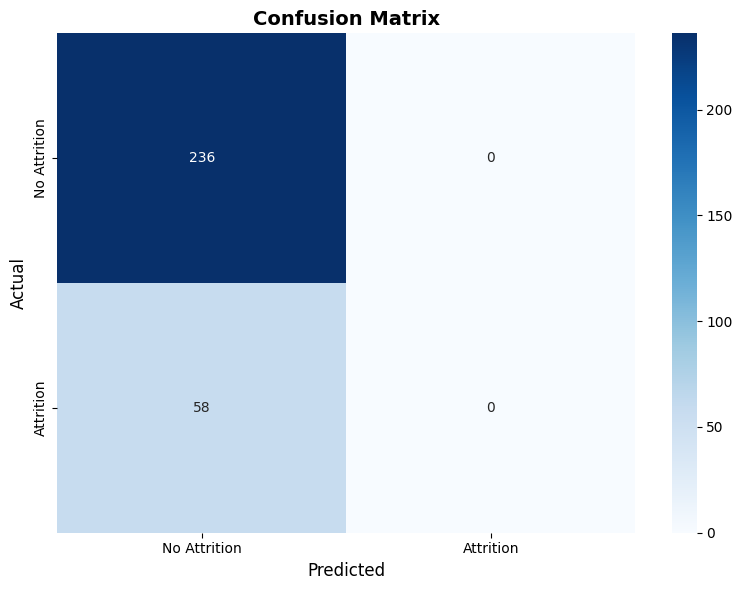

In [19]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Attrition', 'Attrition'],
            yticklabels=['No Attrition', 'Attrition'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

## 10. Visualizations

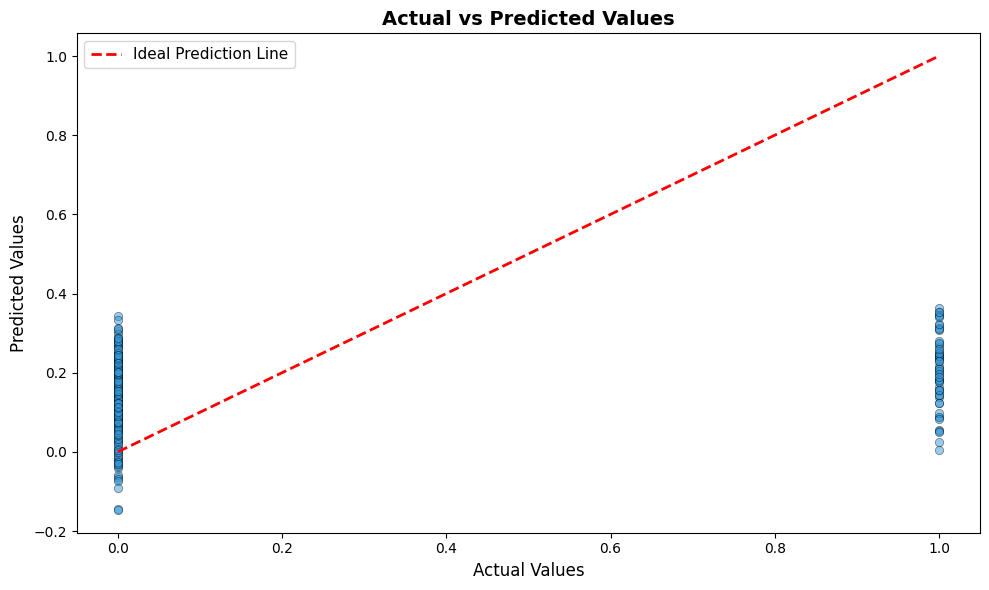

In [20]:
# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='#3498db', edgecolors='black', linewidth=0.5)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Ideal Prediction Line')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

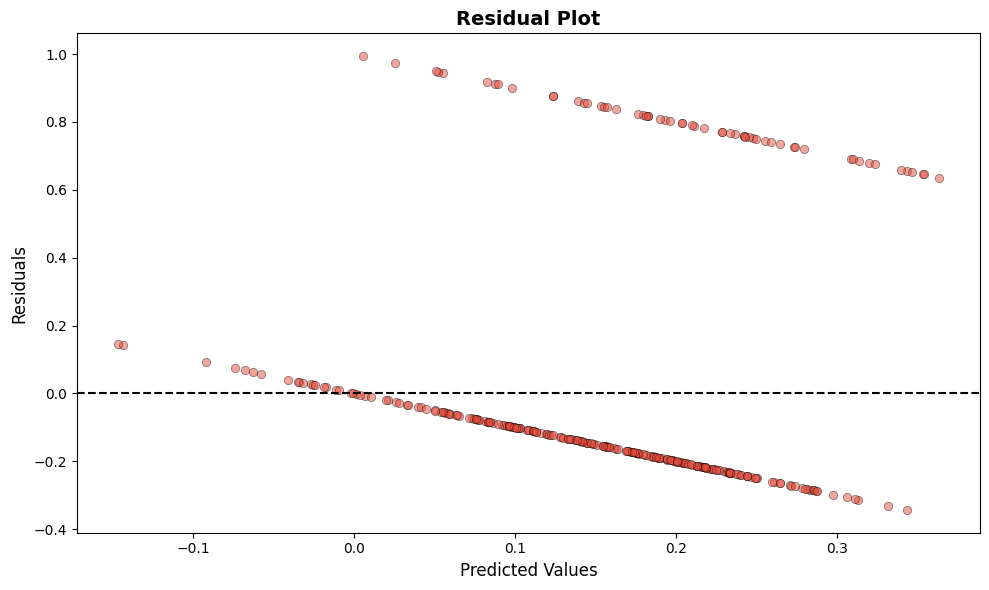

In [21]:
# Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='#e74c3c', edgecolors='black', linewidth=0.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

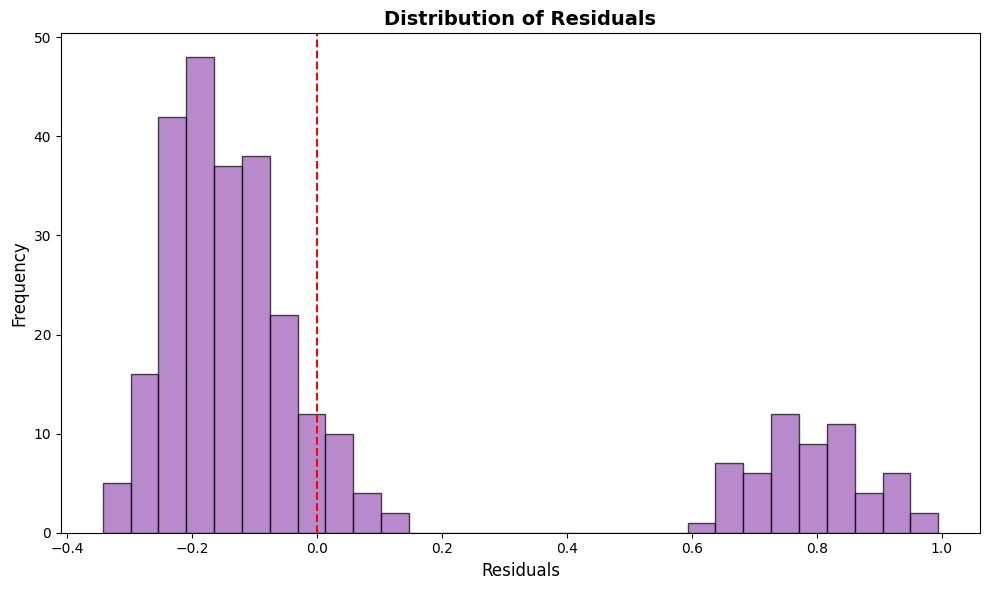

In [22]:
# Distribution of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

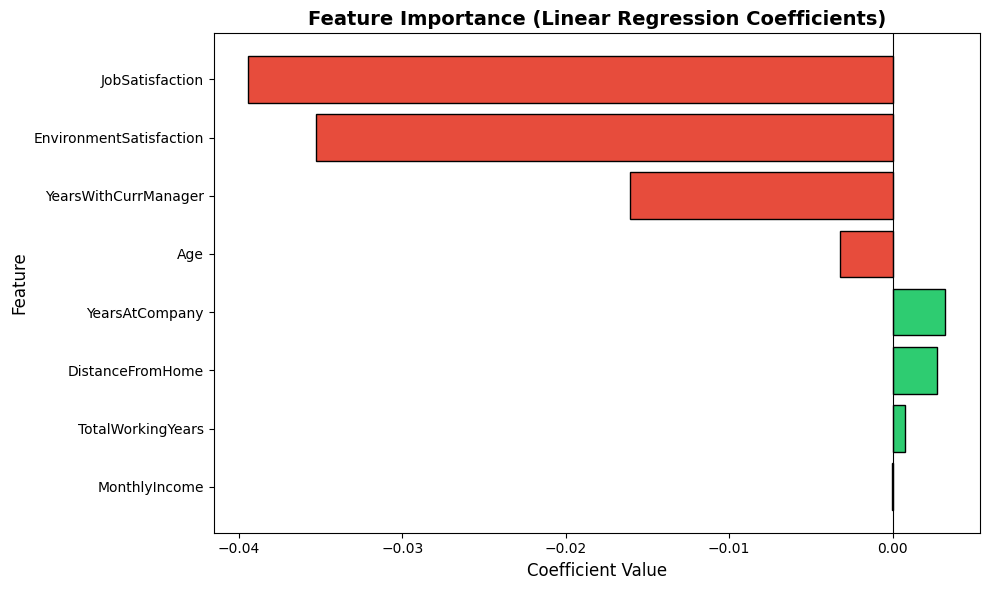

In [23]:
# Feature Importance (Coefficients)
coef_df = pd.DataFrame({
    'Feature': input_features,
    'Coefficient': model.weights
}).sort_values(by='Coefficient', key=abs, ascending=True)

plt.figure(figsize=(10, 6))
colors_bar = ['#e74c3c' if c < 0 else '#2ecc71' for c in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors_bar, edgecolor='black')
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance (Linear Regression Coefficients)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()